In [1]:
!pip -q install -e ../.

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from testgen.analysis_utils import *

In [4]:
df = pd.read_excel("../data/requirements.xlsx")
df.columns = [''.join(word[0].capitalize() for word in col.split('_')) for col in df.columns]

In [5]:
df_t = df.drop(columns="R")

new_cols = df[df_t.sum(axis=1) == 2].drop(columns="R").drop_duplicates().astype(bool).apply(
    lambda x: "&".join(df_t.columns[x]), axis=1
).to_list()

for n in new_cols:
    index_t = df_t[df_t[n.split("&")].sum(axis=1)==2].index
    df.loc[index_t] = 0
    df[n] = 0
    df.loc[index_t, n] = 1

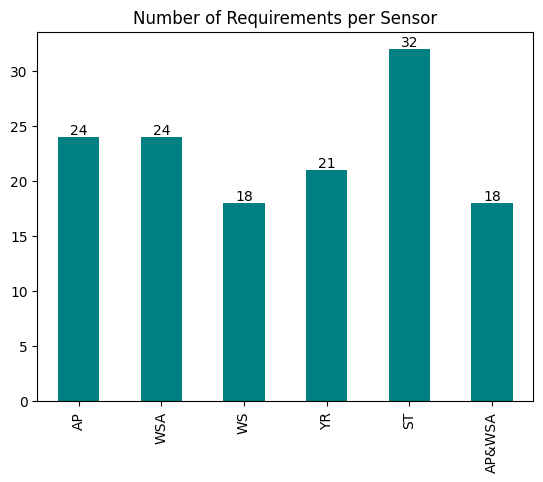

In [6]:
ax = df.drop(columns="R").sum().plot.bar(
    title="Number of Requirements per Sensor",
    color="teal",    
)

_ = ax.bar_label(ax.containers[0])

In [7]:
labels = get_sensors_labels()
labels

array(['Acc', 'WSA', 'WS', 'YR', 'ST'], dtype='<U3')

In [4]:
# read results file
base_path = Path().cwd()
results_path = base_path.parent / "results"
    
results_single = get_best_results(results_path, "single_gpt*.json")
results_bulk = get_best_results(results_path, "bulk*.json")

In [5]:
def plot_summarize(c, summarize_):
    ax = summarize_["accuracy"].plot.bar(
        title="Accuracy per Sensor",
        xlabel="",
    )

    _ = ax.bar_label(ax.containers[0])

In [74]:
def investigate_sensor_in_file(ts, file):
    t_, _ = result_to_df(labels, file, results_path)
    return t_[(t_["true_label"] == ts) & (t_["accuracy"] == False)]["pred_label"].value_counts()

In [75]:
investigate_sensor_in_file("ST", results_single[0])

pred_label
WSA          3
WS & ST      1
Acc & WSA    1
Name: count, dtype: int64

In [6]:
stats_single, summarize_single = analyze_multiple(labels, results_single, results_path)

In [7]:
stats_single

,type,model_name,accuracy,number_of_reqs,total_tokens,total_completion_tokens,avg_token_per_req,avg_completion_token_per_req,avg_time_per_req
number_examples,,,,,,,,,
1,single,gpt-4o-mini,0.934307,137,108961,1781,795.335766,13.0,0.931720
3,single,gpt-4o-mini,0.905109,137,188421,1781,1375.335766,13.0,3.557572
5,single,gpt-4o-mini,0.905109,137,264593,1781,1931.335766,13.0,4.004780
8,single,gpt-4o-mini,0.905109,137,381043,1781,2781.335766,13.0,4.469258


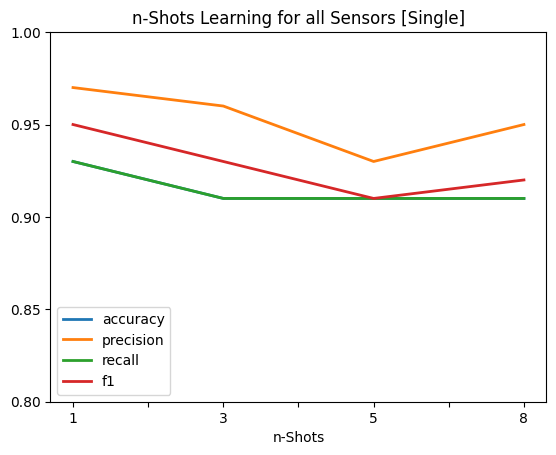

In [63]:
metrics_n_single = summarize_single[summarize_single["sensors"] == "All"].set_index("number_examples").iloc[:, -4:]
metrics_n_single.index = metrics_n_single.index.astype("str")

ax = metrics_n_single.plot.line(
    yticks=[float(r/100) for r in range(80, 101, 5)],
    linewidth=2,
    xlabel="n-Shots",
    title="n-Shots Learning for all Sensors [Single]",
)

ax.legend(loc='lower left')

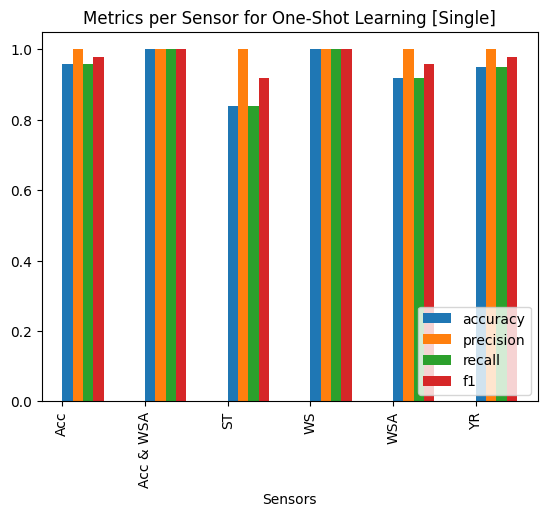

In [49]:
metrics_n_sensor_single = summarize_single[(summarize_single["sensors"] != "All") & (summarize_single["number_examples"] == 1)].set_index(["sensors"]).iloc[:, -4:]

ax = metrics_n_sensor_single.plot.bar(
    linewidth=2,
    xlabel="Sensors",
    title="Metrics per Sensor for One-Shot Learning [Single]",
    align='edge',
)

ax.legend(loc='lower right')

In [85]:
metrics_n_sensor_single

,accuracy,precision,recall,f1
sensors,,,,
Acc,0.96,1.0,0.96,0.98
Acc & WSA,1.00,1.0,1.00,1.00
ST,0.84,1.0,0.84,0.92
WS,1.00,1.0,1.00,1.00
WSA,0.92,1.0,0.92,0.96
YR,0.95,1.0,0.95,0.98


In [10]:
stats_bulk, summarize_bulk = analyze_multiple(labels, results_bulk, results_path)

In [76]:
stats_bulk

,type,model_name,number_examples,accuracy,number_of_reqs,total_tokens,total_completion_tokens,avg_token_per_req,avg_completion_token_per_req,avg_time_per_req
type_n,,,,,,,,,,
2,bulk,gpt-4o-mini,1,0.889706,68,59347,2108,436.375000,15.5,0.476348
3,bulk,gpt-4o-mini,1,0.866667,45,40690,2160,301.407407,16.0,0.186321
5,bulk,gpt-4o-mini,1,0.837037,27,26699,2160,197.770370,16.0,0.165171
8,bulk,gpt-4o-mini,1,0.823529,17,19149,2176,140.801471,16.0,0.149402


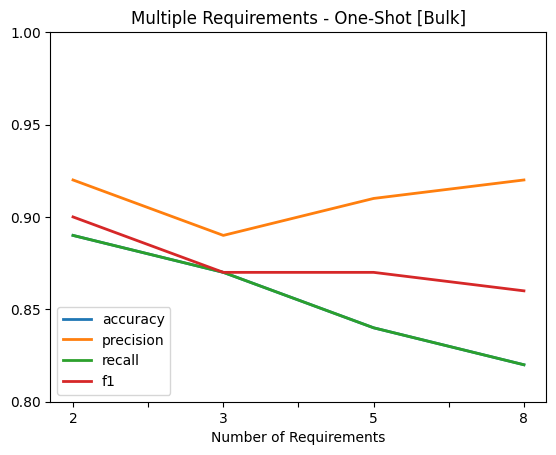

In [62]:
metrics_n_bulk = summarize_bulk[summarize_bulk["sensors"] == "All"].set_index("type_n").iloc[:, -4:]
metrics_n_bulk.index = metrics_n_bulk.index.astype("str")

ax = metrics_n_bulk.plot.line(
    yticks=[float(r/100) for r in range(80, 101, 5)],
    linewidth=2,
    xlabel="Number of Requirements",
    title="Multiple Requirements - One-Shot [Bulk]",
)

ax.legend(loc='lower left')

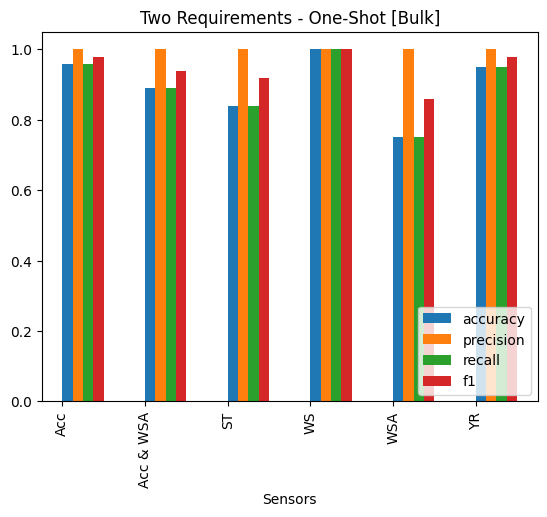

In [53]:
metrics_n_sensor_bulk = summarize_bulk[(summarize_bulk["sensors"] != "All") & (summarize_bulk["type_n"] == 2)].set_index(["sensors"]).iloc[:, -4:]

ax = metrics_n_sensor_bulk.plot.bar(
    linewidth=2,
    xlabel="Sensors",
    title="Two Requirements - One-Shot [Bulk]",
    align='edge',
)

ax.legend(loc='lower right')

In [86]:
metrics_n_sensor_bulk

,accuracy,precision,recall,f1
sensors,,,,
Acc,0.96,1.0,0.96,0.98
Acc & WSA,0.89,1.0,0.89,0.94
ST,0.84,1.0,0.84,0.92
WS,1.00,1.0,1.00,1.00
WSA,0.75,1.0,0.75,0.86
YR,0.95,1.0,0.95,0.98


In [37]:
metrics_n_bulk_t = stats_bulk[["avg_token_per_req"]].merge(metrics_n_bulk, on="type_n")

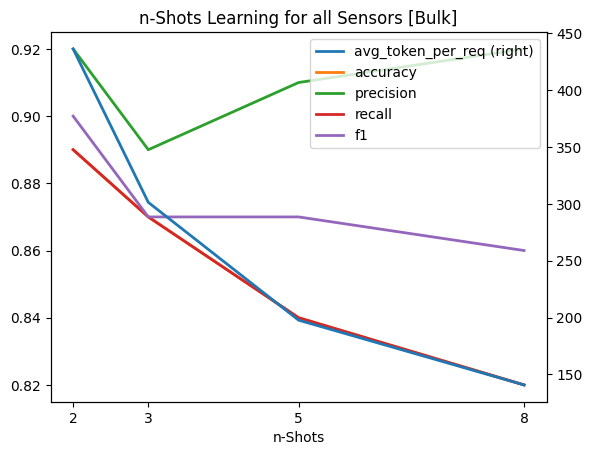

In [38]:
ax = metrics_n_bulk_t.plot.line(
    xticks=metrics_n_bulk.index,
    # yticks=[float(r/100) for r in range(80, 101, 5)],
    linewidth=2,
    secondary_y=["avg_token_per_req"],
    xlabel="n-Shots",
    title="n-Shots Learning for all Sensors [Bulk]",
)

In [87]:
result_llms = get_best_results(results_path, "single_[!dropped]*n-1*.json")

In [89]:
stats_llm, summarize_llm = analyze_multiple(labels, result_llms, results_path)

In [90]:
stats_llm

,type,model_name,accuracy,number_of_reqs,total_tokens,total_completion_tokens,avg_token_per_req,avg_completion_token_per_req,avg_time_per_req
number_examples,,,,,,,,,
1,single,gpt-4o-mini,0.934307,137,108961,1781,795.335766,13.000000,0.931720
1,single,llama-3.2-11b-text-preview,0.861314,137,118098,6252,862.029197,45.635036,6.971447
1,single,llama-3.2-3b-preview,0.598540,137,113745,2858,830.255474,20.861314,6.699515
1,single,llama-3.2-90b-text-preview,0.875912,137,119194,7348,870.029197,53.635036,7.156187
1,single,mixtral-8x7b-32768,0.839416,137,134951,5717,985.043796,41.729927,11.391009


In [ ]:
metrics_n_llm = summarize_llm[summarize_llm["sensors"] == "All"].set_index("model_name").iloc[:, -4:]
metrics_n_llm.index = metrics_n_llm.index.astype("str")

metrics_n_llm

,accuracy,precision,recall,f1
model_name,,,,
gpt-4o-mini,0.93,0.97,0.93,0.95
llama-3.2-11b-text-preview,0.86,0.91,0.86,0.88
llama-3.2-3b-preview,0.60,0.67,0.60,0.58
llama-3.2-90b-text-preview,0.88,0.95,0.88,0.91
mixtral-8x7b-32768,0.84,0.94,0.84,0.88


In [104]:
metrics_n_sensor_llm = summarize_llm[(summarize_llm["sensors"] != "All") & (summarize_llm["model_name"] == "llama-3.2-11b-text-preview")].set_index(["sensors"]).iloc[:, -4:]

metrics_n_sensor_llm

,accuracy,precision,recall,f1
sensors,,,,
Acc,0.92,1.0,0.92,0.96
Acc & WSA,0.72,1.0,0.72,0.84
ST,0.91,1.0,0.91,0.95
WS,1.00,1.0,1.00,1.00
WSA,0.83,1.0,0.83,0.91
YR,0.76,1.0,0.76,0.86


In [105]:
metrics_n_sensor_llm = summarize_llm[(summarize_llm["sensors"] != "All") & (summarize_llm["model_name"] == "llama-3.2-90b-text-preview")].set_index(["sensors"]).iloc[:, -4:]

metrics_n_sensor_llm

,accuracy,precision,recall,f1
sensors,,,,
Acc,0.96,1.0,0.96,0.98
Acc & WSA,0.94,1.0,0.94,0.97
ST,0.84,1.0,0.84,0.92
WS,1.00,1.0,1.00,1.00
WSA,0.67,1.0,0.67,0.80
YR,0.90,1.0,0.90,0.95
